<a href="https://colab.research.google.com/github/SLMath/Study_MachileLearning/blob/main/AdaBoostClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
data = pd.read_csv('https://raw.githubusercontent.com/SLMath/Study_MachileLearning/main/Datasets/german_credit_data.csv')
data

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [35]:
data = data.drop(columns= 'Unnamed: 0')
data.shape

(1000, 10)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.ensemble import AdaBoostClassifier

In [38]:
def pipe_pre_process(df, target):
    # Para facilitação de carregamento e transformação de dados

    # Definição de features e target
    X = df.drop(columns= target)
    y = df[target]

    # Particionamento dos conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    #================================
    # Tratamento dos dados numéricos
    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy = "mean")), # substituindo valores nulos pela média
                                 ("scaler", StandardScaler())]) # padronização dos dados


    features_num = X_train.select_dtypes(include=np.number).columns.tolist() # selecionando apenas as colunas numéricas
    #==============================
    # Tratamento de features categóricas
    pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy = "constant", fill_value = "unknown")), # dados categóricos faltantes
                                 ("onehot", OneHotEncoder())]) # transformação de dados categóricos

    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist() # selecionando apenas colunas categóricas
    #==============================
    # Aplicando as transformações nos nossos dados
    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                        ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

In [39]:
def metricas_classificacao(estimator):
    #=================
    print("\nMétricas da avaliação de treino:")

    y_pred_train = estimator.predict(X_train) # predição sobre os dados de treinamento

    print(confusion_matrix(y_train, y_pred_train)) # matriz de confusão

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    #=================
    print("\nMétricas da avaliação de teste:")

    y_pred_test = estimator.predict(X_test) # predição sobre os dados de treinamento

    print(confusion_matrix(y_test, y_pred_test)) # matriz de confusão

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))


Métricas da avaliação de treino:
[[123 117]
 [ 59 501]]


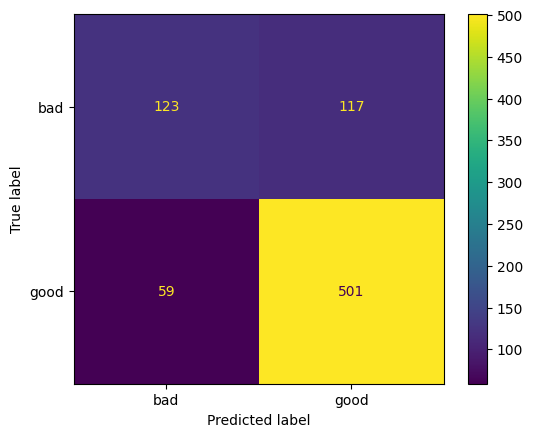

              precision    recall  f1-score   support

         bad       0.68      0.51      0.58       240
        good       0.81      0.89      0.85       560

    accuracy                           0.78       800
   macro avg       0.74      0.70      0.72       800
weighted avg       0.77      0.78      0.77       800


Métricas da avaliação de teste:
[[ 29  31]
 [ 18 122]]


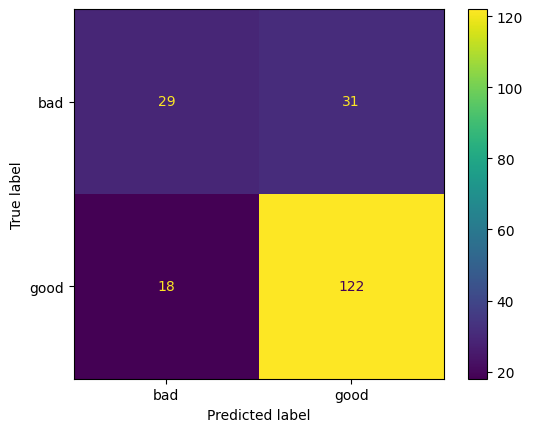

              precision    recall  f1-score   support

         bad       0.62      0.48      0.54        60
        good       0.80      0.87      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.74      0.76      0.75       200



In [43]:
X_train, X_test, y_train, y_test, pre_processador = pipe_pre_process(data, 'Risk')

# pipeline para o Adaboost
pipe_ab = Pipeline([("pre_processador", pre_processador),
                   ("ab", AdaBoostClassifier(random_state = 42))])

# por padrão, n_estimators = 50
pipe_ab.fit(X_train, y_train)

metricas_classificacao(pipe_ab)

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer

parameters = {
    # 'ab__estimator' : ('DecisionTreeClassifier', ''),
    'ab__n_estimators' : range(100, 500, 100),
    # 'ab__learning_rate' : [1, 10],
    'ab__algorithm' : ('SAMME', 'SAMME.R')
}

# we want the model to minimize the error of saying it is good, when it is not
metric = make_scorer(precision_score, pos_label= 'good')

model = GridSearchCV(
    estimator= pipe_ab,
    param_grid= parameters,
    scoring= metric
    )

model.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Job',
                                                                          'Credit '
                                                                          'amount',
                                                                          'Duration']),
                                                                        ('transf_cat',
                                                                         Pipeline(steps=[('input_cat',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'Housing',
                                                                          'Saving '
                                                                          'accounts',
                                                                          'Checking '
                                                                          'account',
                                                                          'Purpose'])])),
                                       ('ab',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'ab__algorithm': ('SAMME', 'SAMME.R'),
                         'ab__n_estimators': range(100, 500, 100)},
             scoring=make_scorer(precision_score, pos_label=good))

In [62]:
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ab__algorithm,param_ab__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.168212,0.003988,0.015576,0.000852,SAMME,100,"{'ab__algorithm': 'SAMME', 'ab__n_estimators':...",0.785714,0.738095,0.761538,0.766129,0.779528,0.766201,0.016553,6
1,0.323811,0.008494,0.025078,0.002270,SAMME,200,"{'ab__algorithm': 'SAMME', 'ab__n_estimators':...",0.803279,0.758065,0.770992,0.753968,0.771654,0.771591,0.017309,4
2,0.477732,0.003697,0.032226,0.001400,SAMME,300,"{'ab__algorithm': 'SAMME', 'ab__n_estimators':...",0.809917,0.758065,0.767442,0.752000,0.771654,0.771815,0.020262,3
3,0.741213,0.106786,0.054327,0.013394,SAMME,400,"{'ab__algorithm': 'SAMME', 'ab__n_estimators':...",0.803279,0.764228,0.769231,0.758065,0.777778,0.774516,0.015763,2
4,0.266755,0.044149,0.028497,0.007106,SAMME.R,100,"{'ab__algorithm': 'SAMME.R', 'ab__n_estimators...",0.811966,0.758065,0.767442,0.752066,0.798387,0.777585,0.023452,1
5,0.468010,0.104509,0.038267,0.007146,SAMME.R,200,"{'ab__algorithm': 'SAMME.R', 'ab__n_estimators...",0.801724,0.758333,0.763780,0.743802,0.779528,0.769433,0.019783,5
6,0.581269,0.138429,0.045015,0.001388,SAMME.R,300,"{'ab__algorithm': 'SAMME.R', 'ab__n_estimators...",0.780488,0.760684,0.761905,0.721311,0.776000,0.760078,0.020864,8
7,0.785467,0.094339,0.068598,0.009696,SAMME.R,400,"{'ab__algorithm': 'SAMME.R', 'ab__n_estimators...",0.782258,0.752137,0.761905,0.745902,0.766129,0.761666,0.012517,7



Métricas da avaliação de treino:
[[132 108]
 [ 60 500]]


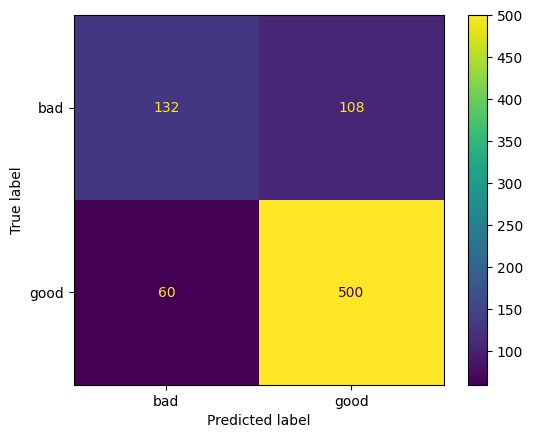

              precision    recall  f1-score   support

         bad       0.69      0.55      0.61       240
        good       0.82      0.89      0.86       560

    accuracy                           0.79       800
   macro avg       0.75      0.72      0.73       800
weighted avg       0.78      0.79      0.78       800


Métricas da avaliação de teste:
[[ 27  33]
 [ 20 120]]


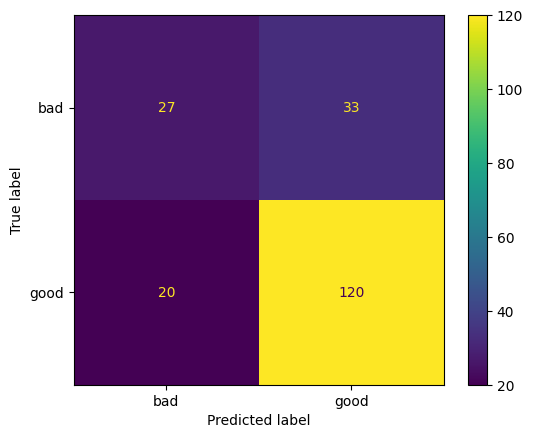

              precision    recall  f1-score   support

         bad       0.57      0.45      0.50        60
        good       0.78      0.86      0.82       140

    accuracy                           0.73       200
   macro avg       0.68      0.65      0.66       200
weighted avg       0.72      0.73      0.72       200



In [63]:
metricas_classificacao(model)

From 0.80 to 0.78. It was not an improvement

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

parameters = {
    'ab__estimator' : (DecisionTreeClassifier(max_depth= 2), LogisticRegression()),
    'ab__n_estimators' : range(100, 500, 100),
    # 'ab__learning_rate' : [1, 10],
    # 'ab__algorithm' : ('SAMME', 'SAMME.R')
}

# we want the model to minimize the error of saying it is good, when it is not
metric = make_scorer(precision_score, pos_label= 'good')

model = GridSearchCV(
    estimator= pipe_ab,
    param_grid= parameters,
    scoring= metric
    )

model.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Job',
                                                                          'Credit '
                                                                          'amount',
                                                                          'Duration']),
                                                                        ('transf_cat',
                                                                         Pipeline(steps=[('input_cat',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'Housing',
                                                                          'Saving '
                                                                          'accounts',
                                                                          'Checking '
                                                                          'account',
                                                                          'Purpose'])])),
                                       ('ab',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'ab__estimator': (DecisionTreeClassifier(max_depth=2),
                                           LogisticRegression()),
                         'ab__n_estimators': range(100, 500, 100)},
             scoring=make_scorer(precision_score, pos_label=good))

In [66]:
model.best_estimator_

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('ab',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                    n_estimators=200, random_state=42))])


Métricas da avaliação de treino:
[[240   0]
 [  0 560]]


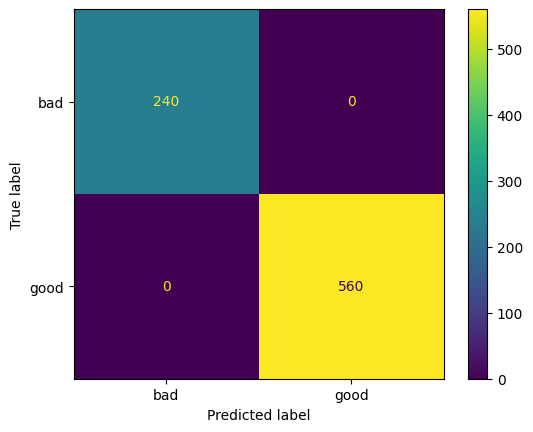

              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       240
        good       1.00      1.00      1.00       560

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Métricas da avaliação de teste:
[[ 31  29]
 [ 25 115]]


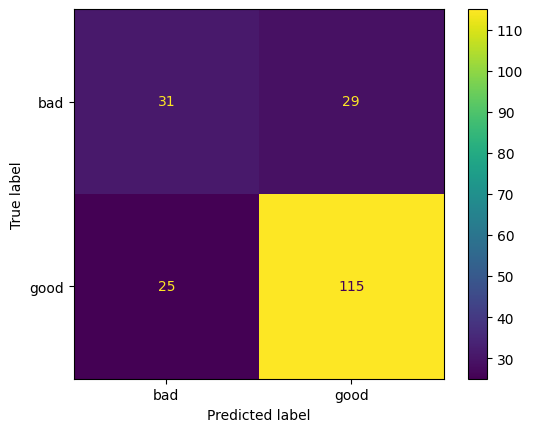

              precision    recall  f1-score   support

         bad       0.55      0.52      0.53        60
        good       0.80      0.82      0.81       140

    accuracy                           0.73       200
   macro avg       0.68      0.67      0.67       200
weighted avg       0.73      0.73      0.73       200



In [65]:
metricas_classificacao(model)

It has not improved in precision.
But it did got worse in respect to recall and precision.